## Differential expression of polyA-selected vs ribo-depleted

This notebook compares 6 matched samples generated using both polyA-selected and ribo-depleted strategies. Then highlights the DEGs on the correlation plot to determine if the uncorrelated genes are those that are due to differences in protocol.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np

from rpy2.robjects import pandas2ri
from ponyo import utils
from generic_expression_patterns_modules import stats, ranking

pandas2ri.activate()
np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
col_to_rank_genes = params["rank_genes_by"]
project_id = params["project_id"]

## Differential expression analysis

**RSEM**:
* What is RSEM doing?
* What are the estimated count outputs?
* gene vs transcript vs isoform level?

**tximport**:
* What is this doing?
* Is this needed for DESeq?

Note we will be rounding estimated gene counts from RSEM.

Should be using tximport to get counts corrected for by gene length, but raw data isn't available

https://support.bioconductor.org/p/94003/#94028

**DESeq2 normalization**:

Normalization is needed to perform a fair comparison -- why.

The main factors considered during normalization include:
1. sequence depth/coverage = the number of unique reads that map to a region
2. gene length = longer genes tend to have more reads mapped
3. RNA composition = what genes are expressed and how active

When performing a DE analysis, since we're comparing match gene pairs, we only need to consider sequence depth and RNA composition. DESeq2 accounts for these in its median ratio --- scale sample counts by median of ratios for sample counts vs reference pseudo count per gene

How to deal with normalization and DESeq2: https://hbctraining.github.io/DGE_workshop/lessons/02_DGE_count_normalization.html

* Comparison


In [3]:
## TO DO
## Replace integer rounding to tximport
## Update dds call to use tximport object

mapped_expression_filename = "polya_ribo_expression.tsv"
processed_expression_filename = "polya_ribo_expression_processed.tsv"
metadata_filename = "polya_ribo_sample_grouping.tsv"

stats.process_samples_for_DESeq(
    mapped_expression_filename,
    metadata_filename,
    processed_expression_filename,
)

sample ids are ordered correctly


In [4]:
%%R -i metadata_filename -i processed_expression_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   "polyA_vs_ribo",
                   processed_expression_filename,
                   "template",
                   local_dir,
                   "pbta")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] "Checking sample ordering..."
[1] TRUE


In [5]:
# Get DEGs
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", "DE_stats_template_data_polyA_vs_ribo_pbta.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, sep="\t", header=0, index_col=0
)

selected = template_DE_stats[
    (template_DE_stats["padj"] < 0.01) & (abs(template_DE_stats["log2FoldChange"]) > 1)
]
DEGs = list(selected.index)
print(len(DEGs))
selected.head()

331


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DNAJB7,7.530591,-5.625932,1.328206,-4.235736,0.000023,0.001566
APC,12407.898060,1.492720,0.398849,3.742573,0.000182,0.007864
ARID1B,7806.808788,1.315714,0.353659,3.720295,0.000199,0.008273
DYNC2H1,2764.566092,1.649016,0.372155,4.430986,0.000009,0.000726
DYNC1H1,51047.826510,1.161527,0.271325,4.280945,0.000019,0.001335


## Plot

In [6]:
# Load gene_summary_filename
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
)

summary_gene_ranks = pd.read_csv(gene_summary_filename, sep="\t", index_col=0, header=0)

In [7]:
summary_gene_ranks.loc[DEGs]

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
DNAJB7,DNAJB7,7.796922e-01,3650.0,0.163941,0.163941,5.103037e-02,6353.0,35.777853,0.040000,0.470359,0.408423,25,-0.750246
APC,APC,9.109256e-01,595.0,0.022401,-0.022401,4.908618e-02,900.0,5.063648,0.120000,0.453691,0.703519,25,-0.613047
ARID1B,ARID1B,5.986978e-01,2174.0,0.090542,-0.090542,1.040533e-03,5366.0,30.218542,0.040000,0.431096,0.294107,25,-1.157922
DYNC2H1,DYNC2H1,9.111624e-01,601.0,0.022580,0.022580,2.770527e-02,6951.0,39.146108,0.240000,0.636770,0.506433,25,-1.212778
DYNC1H1,DYNC1H1,9.002415e-01,785.0,0.029726,-0.029726,1.233740e-01,1313.0,7.389884,0.080000,0.316655,0.311749,25,-0.920384
ANKRD44.IT1,ANKRD44.IT1,9.048114e-01,2136.0,0.089176,-0.089176,3.358492e-02,13508.0,76.078630,0.458333,1.344839,1.236329,24,-1.015638
CEP192,CEP192,7.101494e-02,5847.0,0.262926,0.262926,5.028763e-02,2792.0,15.720401,0.080000,0.495948,0.813597,25,-0.286409
CNTD1,CNTD1,3.981704e-05,9719.0,0.508311,0.508311,1.272206e-08,8970.0,50.518193,0.160000,0.663857,0.497277,25,-0.312796
RNF169,RNF169,7.197720e-03,5116.0,0.231969,0.231969,1.579143e-02,4341.0,24.445195,0.080000,0.465140,0.443700,25,-0.525514
ST7.OT4,ST7.OT4,8.754825e-01,1341.0,0.054064,-0.054064,4.427770e-04,9556.0,53.818858,0.280000,0.730821,0.666343,25,-1.015629


r = 0.1851597404594152
p = 3.711325673092676e-132
ci_low = 0.16986063531015294
ci_high = 0.19973560919413683


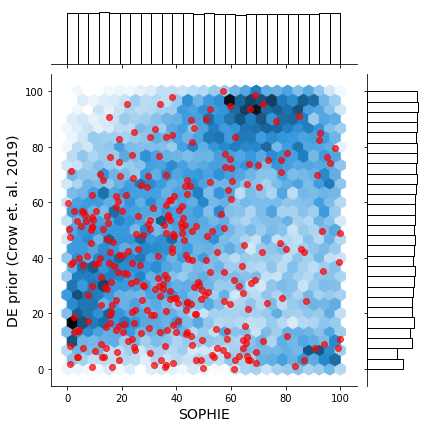

In [16]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}_highlight_polyA_vs_ribo.svg"

corr, shared_ranking = ranking.compare_gene_ranking_highlight(
    summary_gene_ranks,
    DE_prior_filename,
    ref_gene_col,
    ref_rank_col,
    DEGs,
    figure_filename,
)